In [1]:
import pandas as pd 
import numpy as np
import glob
import os

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from selectpairs import build_pair_universe
from backtest import backtest_pair
from buyandhold import buyhold_benchmark_neutral
from metrics import compute_pair_metrics
from plotpairs import plot_strategy_vs_benchmark



In [2]:
close = pd.read_csv('../data/close_prices.csv')
# test on lstm outputs first
folder_path = "../LSTM/outputs"

prediction_files = glob.glob(os.path.join(folder_path, "*_predictions.csv"))

dfs = {}
for file in prediction_files:
    name = os.path.basename(file).replace("_predictions.csv", "")
    dfs[name] = pd.read_csv(file)


all_predictions = pd.concat(
    [df.assign(stock=name) for name, df in dfs.items()],
    ignore_index=True
)

predicted = (
    all_predictions
    .pivot(index="Date", columns="stock", values="PredictedPrice")
    .reset_index()
)
display(predicted.head())

stock,Date,AAPL,AMZN,AVGO,GOOGL,META,MSFT,NFLX,NVDA,ORCL,QQQ,SPY,TSLA
0,2023-01-03,114.519516,78.36307,33.496550,63.563602,155.53108,195.68138,304.99542,13.643364,53.049305,165.93988,274.80026,107.360420
1,2023-01-04,113.716484,78.91684,33.637490,63.808025,155.41907,196.17316,305.21637,13.630103,53.495940,165.78568,274.28726,112.083360
2,2023-01-05,113.074950,79.44042,33.770462,63.931328,155.22202,196.40758,307.19970,13.620599,53.997230,165.78750,273.61750,118.941246
3,2023-01-06,112.474890,79.90562,33.872746,64.022820,154.95824,196.31615,310.08636,13.621037,54.468426,165.78844,272.39505,127.969570
4,2023-01-09,112.014720,80.20997,34.276447,64.002650,154.82167,196.01443,313.29813,13.635827,54.990013,166.02893,271.67776,138.273740


In [3]:
pair_df = build_pair_universe(
    close_df=close,
    train_end="2023-01-01",
    corr_threshold=0.8,
    min_len=200,
    pval_threshold=0.05,
    top_n=5
)

pair_df


,stock1,stock2,pvalue,alpha,beta,mu,sigma,n_obs
0,GOOGL,SPY,0.000710,-4.133232,1.482024,-4.133232,0.087764,3272
1,ORCL,SPY,0.007939,-0.518246,0.793261,-0.518246,0.081085,3272
2,GOOGL,ORCL,0.013004,-2.864890,1.785789,-2.864890,0.176204,3272
3,AAPL,ORCL,0.013883,-4.651317,2.231606,-4.651317,0.235064,3272
4,GOOGL,QQQ,0.017971,-1.503294,1.080642,-1.503294,0.095780,3272


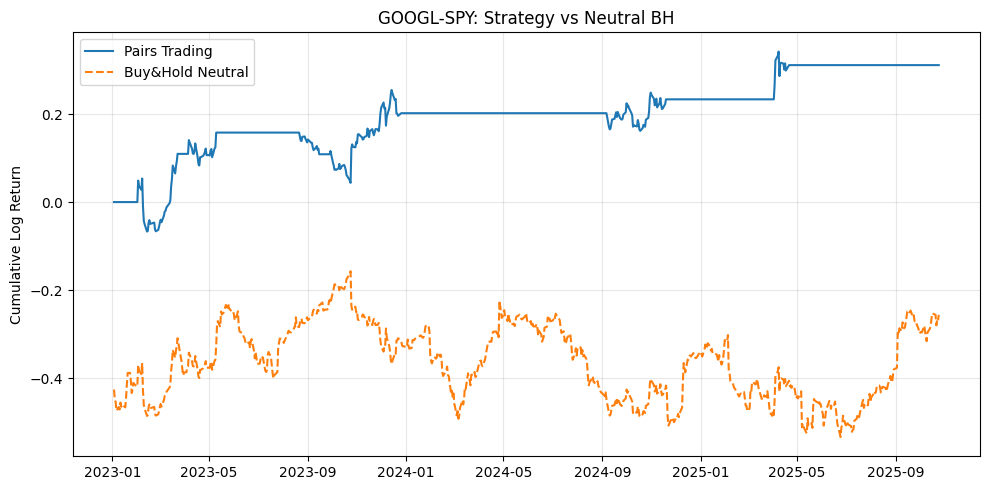

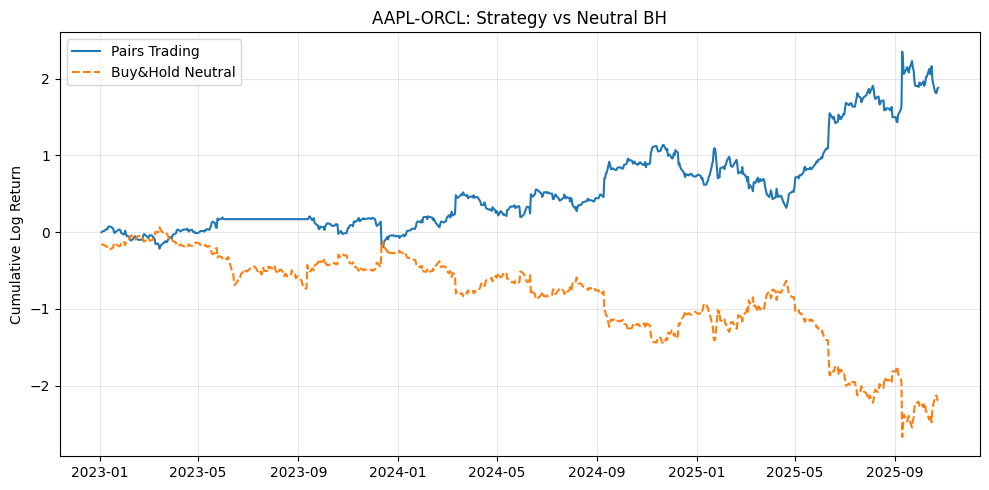

== Strategy vs Neutral Buy&Hold (aligned)==


,Strat_CumRet,Strat_AnnRet,Strat_AnnVol,Strat_Sharpe,Strat_MaxDD,Strat_WinRt,BH_CumRet,BH_AnnRet,BH_AnnVol,BH_Sharpe,BH_MaxDD,BH_WinRt,Days
Pair,,,,,,,,,,,,,
GOOGL-SPY,0.3652,0.1175,0.1355,0.8203,-0.1136,0.1572,-0.2261,-0.0874,0.2485,0.2674,-0.3139,0.5212,706
AAPL-ORCL,5.5565,0.9566,0.8661,0.7749,-0.5602,0.4915,-0.8888,-0.5434,0.9048,-0.8436,-0.9350,0.4490,706


== Excess (Strategy - BH-Neutral) ==


,Excess_AnnRet,Excess_Sharpe,Excess_CumRet
Pair,,,
GOOGL-SPY,0.2050,0.5530,0.5914
AAPL-ORCL,1.5001,1.6186,6.4453


In [4]:
pairs_to_use = [
    ("GOOGL", "SPY"),
    ("AAPL", "ORCL"),
]

results = {}
benchmarks = {}
metrics_rows = []          
excess_rows = []         

for s1, s2 in pairs_to_use:
    match = pair_df[(pair_df["stock1"] == s1) & (pair_df["stock2"] == s2)]
    if match.empty:
        print(f"⚠️ Pair ({s1}, {s2}) not found in pair_df, skipped.")
        continue

    row = match.iloc[0]
    key = (s1, s2)

    res = backtest_pair(predicted, close, row)
    results[key] = res

    bh = buyhold_benchmark_neutral(close, row)
    idx = res.index.intersection(bh.index)
    bh_aligned = bh.loc[idx].copy()
    res_aligned = res.loc[idx].copy()
    benchmarks[key] = bh_aligned

    plot_strategy_vs_benchmark(res_aligned, bh_aligned, title=f"{s1}-{s2}: Strategy vs Neutral BH")

    #compute_pair_metrics
    m_strat = compute_pair_metrics(res_aligned)
    m_bh    = compute_pair_metrics(bh_aligned)

    metrics_rows.append({
        "Pair": f"{s1}-{s2}",
        # strategy
        "Strat_CumRet": m_strat["CumulativeReturn"],
        "Strat_AnnRet": m_strat["AnnualizedReturn"],
        "Strat_AnnVol": m_strat["AnnualVolatility"],
        "Strat_Sharpe": m_strat["SharpeRatio"],
        "Strat_MaxDD" : m_strat["MaxDrawdown"],
        "Strat_WinRt" : m_strat["WinRate"],
        # benchmark
        "BH_CumRet": m_bh["CumulativeReturn"],
        "BH_AnnRet": m_bh["AnnualizedReturn"],
        "BH_AnnVol": m_bh["AnnualVolatility"],
        "BH_Sharpe": m_bh["SharpeRatio"],
        "BH_MaxDD" : m_bh["MaxDrawdown"],
        "BH_WinRt" : m_bh["WinRate"],
        "Days": m_strat["Days"]
    })

    excess_rows.append({
        "Pair": f"{s1}-{s2}",
        "Excess_AnnRet": (m_strat["AnnualizedReturn"] - m_bh["AnnualizedReturn"]),
        "Excess_Sharpe": (m_strat["SharpeRatio"] - m_bh["SharpeRatio"]),
        "Excess_CumRet": (m_strat["CumulativeReturn"] - m_bh["CumulativeReturn"]),
    })

df_metrics = pd.DataFrame(metrics_rows).set_index("Pair")
df_excess  = pd.DataFrame(excess_rows).set_index("Pair")


print("== Strategy vs Neutral Buy&Hold (aligned)==")
display(df_metrics.round(4))

print("== Excess (Strategy - BH-Neutral) ==")
display(df_excess.round(4))